### CASA0002

# Urban Simulation
***
## Community Detection

Mateo Neira
***

In this lab we well go over the practical implementation of 

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### A Short Intro to Community Detection in Python

We will be using [NetworkX](http://networkx.org/documentation/networkx-2.5/) to create our networks and the [CDlib](https://cdlib.readthedocs.io/en/latest/) python library to run the different community detection algorithms.

In some cases we will use community detection algorithms available from the NetworkX library, you can check the available algorithms [here](http://networkx.org/documentation/networkx-2.5/reference/algorithms/community.html).

Before we get into the **Urban/Spatial** side of things, where we will be looking at how to build a street network graph, and find *neighbourhoods* from the network topology, we are going in a little detour just to show you how to to use the community detection algorithms in python for social networks.

### Exploring the Marvel Universe

![](marvel.jpg)

We will be using the Marvel Universe as an example of a social collaboration network. The network was created by Cesc Rosselló and Ricardo Alberich,

Nodes in the network are Marvel characters, these characters are linked if they jointly appear in the same Marvel comic book. The data was collected from the [Marvel Chronology Project](https://www.chronologyproject.com/).

In [2]:
# let's read the data and quickly see what we have
marvel_network = pd.read_csv('data/hero-network.csv')
marvel_network.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [3]:
# we can create the network using networkx from_pandas_edgelist
G = nx.from_pandas_edgelist(marvel_network, 'hero1', 'hero2')

# lets also plot some basic information about the network
print(nx.info(G))
print(f'Number of connected components:{nx.number_connected_components(G)}')
print(f'Highest degree node: {sorted(G.degree(), key=lambda pair: pair[1])[-1]}')

Name: 
Type: Graph
Number of nodes: 6426
Number of edges: 167219
Average degree:  52.0445
Number of connected components:4
Highest degree node: ('CAPTAIN AMERICA', 1908)


In [4]:
pos = nx.spring_layout(G)

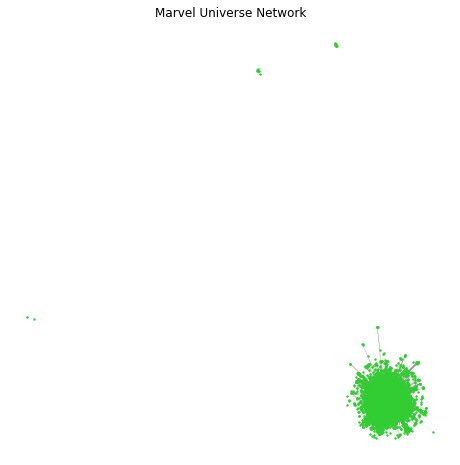

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_edges(G,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       ax=ax
                      )
nx.draw_networkx_nodes(G, 
                       pos=pos,
                       node_color='limegreen',
                       node_size=2,
                       ax=ax
                      )
plt.axis("off")
plt.title('Marvel Universe Network', fontsize=12)
plt.show()

In [6]:
#let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Gsub = G.subgraph(Gcc[0])
lb = '\n \t'
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Name: 
Type: Graph
Number of nodes: 6408
Number of edges: 167163
Average degree:  52.1732
Number of connected components:1
Highest degree nodes: 
 	CAPTAIN AMERICA: 1908
 	SPIDER-MAN/PETER PAR: 1737
 	IRON MAN/TONY STARK : 1522
 	THING/BENJAMIN J. GR: 1416
 	MR. FANTASTIC/REED R: 1379


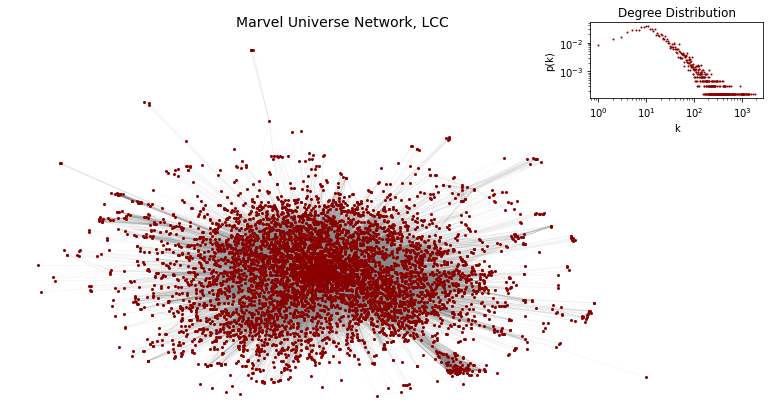

In [7]:
# pos = nx.spring_layout(Gsub)
fig, ax = plt.subplots(figsize=(12,7))

#plot degree distribution
nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='darkred',
                       node_size=4,
                       ax=ax
                      )
ax.axis('off')
ax.set_title('Marvel Universe Network, LCC', fontsize=14)


degree_hist = nx.degree_histogram(G) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/G.number_of_nodes()

ax2 = fig.add_axes([0.8, 0.75, 0.2, 0.15])
ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title('Degree Distribution')


plt.show()

#### What communities can we find in this marvel universe?

We will start by measuring the clustering coefficients of the network.

Remember:

$$ C_i = \frac{2L_i}{k_i(k_i-1)} $$

where $ L_i $ represents the number of links between the  $ k_i $ neighbours of node $i$. 

$C$ in $[0,1]$

In [8]:
#lets measure the clustering coefficient
c = nx.clustering(Gsub)
c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
print('first five heros with highest clustering coefficient: \n \t' + '\n \t'.join([hero[0] for hero in c[0:5]]))

#what is the average clustering coefficient
c_avg = sum([i[1] for i in c]) / len(c)
print(f'avg clustering coefficient: {c_avg}')

first five heros with highest clustering coefficient: 
 	ZANIAC/BRAD WOLFE
 	LUMLEY, JUDY
 	MCCORMICK, BARRY
 	STAR THIEF II
 	CONOVER, REV. WILLIA
avg clustering coefficient: 0.7744001182184579


#### Ok, can we partition this graph into something meaningful?

In [9]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

communities_fg = list(greedy_modularity_communities(Gsub))
print(f'number of communities: {len(communities_fg)}')

number of communities: 66


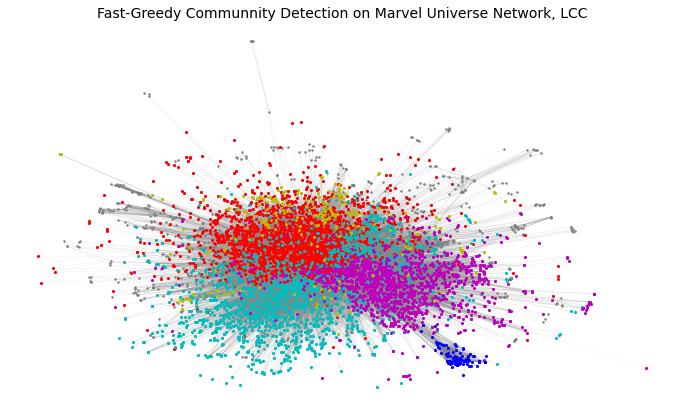

In [10]:
communities_fg = sorted(communities_fg)

fig, ax = plt.subplots(figsize=(12,7))

i=0
cls = ['r', 'c', 'm', 'y', 'b']
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_fg[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Fast-Greedy Communnity Detection on Marvel Universe Network, LCC', fontsize=14)

plt.show()

In [11]:
deg = sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)

In [12]:
for i, community in enumerate(communities_fg[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')
    

community 0:
	 CAPTAIN AMERICA
	 IRON MAN/TONY STARK 
	 THING/BENJAMIN J. GR
	 MR. FANTASTIC/REED R
	 HUMAN TORCH/JOHNNY S
community 1:
	 SPIDER-MAN/PETER PAR
	 DAREDEVIL/MATT MURDO
	 JAMESON, J. JONAH
	 WATSON-PARKER, MARY 
	 ROBERTSON, JOE
community 2:
	 WOLVERINE/LOGAN 
	 BEAST/HENRY &HANK& P
	 STORM/ORORO MUNROE S
	 PROFESSOR X/CHARLES 
	 COLOSSUS II/PETER RA
community 3:
	 FURY, COL. NICHOLAS 
	 BUCKY/BUCKY BARNES
	 TORO/TOM RAYMOND
	 PIXIE/ [ETERNAL]
	 YELLOW CLAW/TZING JA
community 4:
	 BRUTE | MUTANT X-VER
	 BLOODSTORM | MUTANT 
	 ICE-MAN | MUTANT X-V
	 SUMMERS, SCOTT III |
	 CAPTAIN AMERICA | MU


In [13]:
from cdlib import algorithms

partitions = algorithms.louvain(Gsub)
communities_louvain = partitions.communities
print(f'number of communities: {len(communities_louvain)}')

number of communities: 23


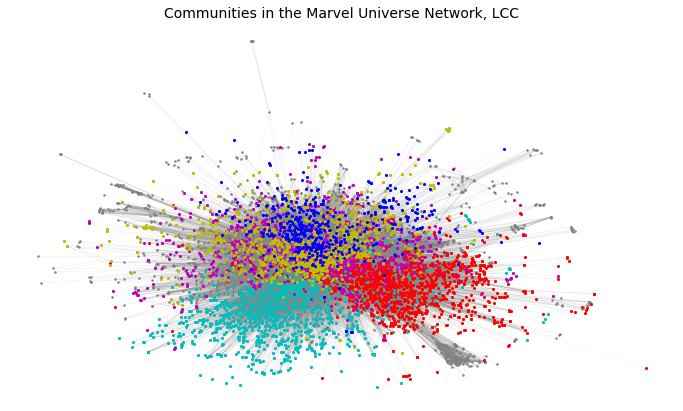

In [14]:
communities_louvain = sorted(communities_louvain, key=lambda x: len(x), reverse=True)

fig, ax = plt.subplots(figsize=(12,7))

i=0
cls = ['r', 'c', 'm', 'y', 'b']
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_louvain[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Communities in the Marvel Universe Network, LCC', fontsize=14)

plt.show()

In [15]:
for i, community in enumerate(communities_louvain[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')

community 0:
	 WOLVERINE/LOGAN 
	 BEAST/HENRY &HANK& P
	 CYCLOPS/SCOTT SUMMER
	 ANGEL/WARREN KENNETH
	 STORM/ORORO MUNROE S
community 1:
	 SPIDER-MAN/PETER PAR
	 DAREDEVIL/MATT MURDO
	 JAMESON, J. JONAH
	 WATSON-PARKER, MARY 
	 ROBERTSON, JOE
community 2:
	 THING/BENJAMIN J. GR
	 MR. FANTASTIC/REED R
	 HUMAN TORCH/JOHNNY S
	 VISION 
	 INVISIBLE WOMAN/SUE 
community 3:
	 CAPTAIN AMERICA
	 IRON MAN/TONY STARK 
	 SCARLET WITCH/WANDA 
	 HAWK
	 WASP/JANET VAN DYNE 
community 4:
	 THOR/DR. DONALD BLAK
	 DR. STRANGE/STEPHEN 
	 THUNDERSTRIKE/ERIC K
	 WONG
	 LOKI [ASGARDIAN]


#### So how good are these partitions?

One way to compare the two partitions we have is to measure the modularity of the resulting network partitions. 

We can do this easily with networkx:
* Modularity
* Performance

https://networkx.org/documentation/networkx-2.5/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html#networkx.algorithms.community.quality.modularity

In [16]:
from networkx.algorithms.community.quality import modularity

print(f'modularity of fast-greedy: {modularity(Gsub, communities_fg)}')
print(f'modularity of louvain: {modularity(Gsub, communities_louvain)}')

modularity of fast-greedy: 0.35876116090404014
modularity of louvain: 0.41929958949327734


In [17]:
from networkx.algorithms.community.quality import performance

print(f'performance of fast-greedy: {performance(Gsub, communities_fg)}')
print(f'performance of louvain: {performance(Gsub, communities_louvain)}')

performance of fast-greedy: 0.7481262204046097
performance of louvain: 0.858172104987386


### Street Network analysis

Now that we have seen how to discover communities in a network, visualize the results 

-image from marshall

Explanation of Open Street Maps
https://www.openstreetmap.org

Data Structure and API
https://overpass-turbo.eu/

#### the OSMnx library

Python library that lets you download spatial data from OpenStreetMap and analyze street networks.
https://osmnx.readthedocs.io/en/stable/

OSMnx is built on top of GeoPandas, and Networkx:
* Downloads and creates a networkx graph ofstreet networks or other infrastructure networks
    * Automatically cleans(topologically corrects) the network for you. 
* Download any other spatial geometries (buildings, POI's, place boundaries)



In [18]:
# We can build a graph by giving the name of the place
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
print(type(G))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


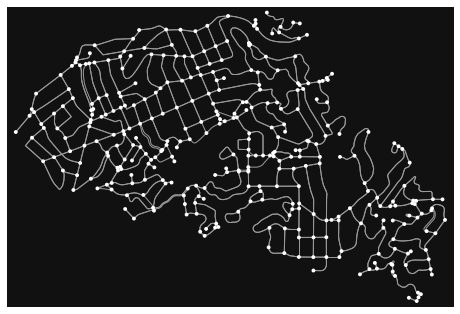

In [19]:
fig, ax = ox.plot_graph(G)

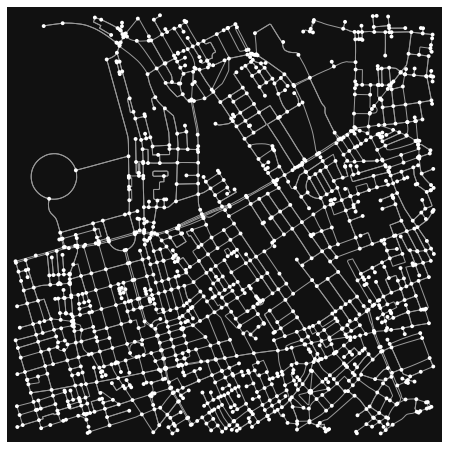

In [20]:
# We can also build a graph by giving the coordinates and a radius
ucl = (51.5245593,-0.1358805)
radius = 1500 #meters
G = ox.graph_from_point(ucl, dist=radius, network_type='drive')
fig, ax = ox.plot_graph(G)

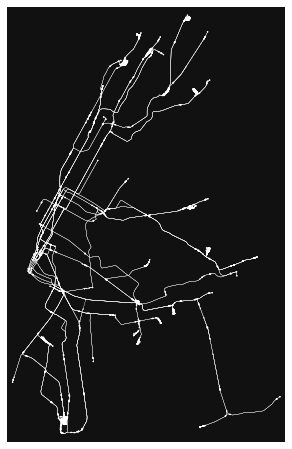

In [21]:
# We can also get other infrastructure networks
G = ox.graph_from_place('New York City, New York',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, node_size=2, edge_color='w', edge_linewidth=0.2)

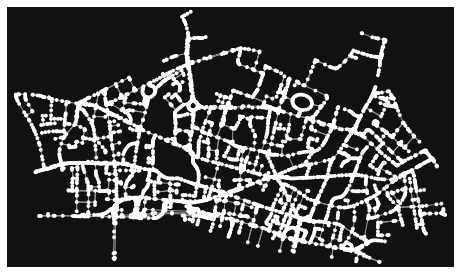

In [22]:
# to keep it light, we will only be using the city of London
place = 'City of London, Greater London, England, United Kingdom'

G = ox.graph_from_place(place, network_type='drive', simplify=False)
fig, ax = ox.plot_graph(G)

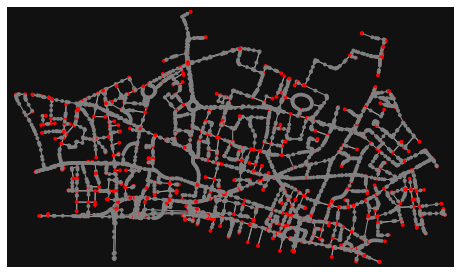

In [23]:
nc = ['r' if ox.simplification._is_endpoint(G, node) else 'grey' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

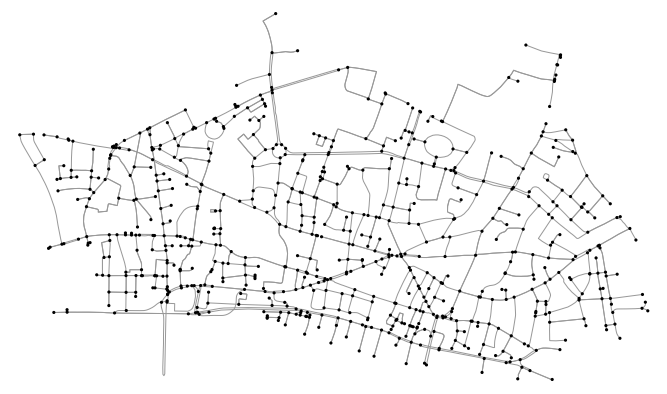

In [24]:
# simplify the network
fig, ax = plt.subplots(figsize=(12,7))
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, 
                        node_color='k',
                        node_size = 10,
                        ax=ax)

In [25]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats

{'n': 696,
 'm': 1388,
 'k_avg': 3.9885057471264367,
 'intersection_count': 564,
 'streets_per_node_avg': 2.6652298850574714,
 'streets_per_node_counts': {0: 0, 1: 132, 2: 54, 3: 441, 4: 55, 5: 12, 6: 2},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.1896551724137931,
  2: 0.07758620689655173,
  3: 0.6336206896551724,
  4: 0.07902298850574713,
  5: 0.017241379310344827,
  6: 0.0028735632183908046},
 'edge_length_total': 87981.76000000001,
 'edge_length_avg': 63.38743515850145,
 'street_length_total': 59003.47300000002,
 'street_length_avg': 65.63233926585097,
 'street_segments_count': 899,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0621840997991647,
 'self_loop_proportion': 0.002161383285302594,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [26]:
# lets use random walk, as it's fairly intuive in this setting
partitions = algorithms.walktrap(G)
neighbourhoods = partitions.communities

In [27]:
# let us print some basic states about the communities found
n_comm = len(neighbourhoods)
mod = modularity(G, neighbourhoods)

#performance does not take multigraph
G_collapsed = ox.utils_graph.get_digraph(G, weight='length')
performance = performance(G_collapsed, neighbourhoods)
print(f"""
{n_comm} communities found
modularity: {mod}
performance: {performance}
""")


31 communities found
modularity: 0.8705827637468961
performance: 0.9525986107665592



In [28]:
#lets plot to get a better idea of

In [29]:
# let's build a dictionary with nodes as keys and cluster assignment
node_assignment = {}
for cluster, neighbourhood in enumerate(neighbourhoods):
    for node in neighbourhood:
        node_assignment[node] = cluster

In [30]:
nx.set_node_attributes(G, node_assignment, 'cluster')

In [31]:
cls = ox.plot.get_node_colors_by_attr(G, 'cluster', cmap='tab20')

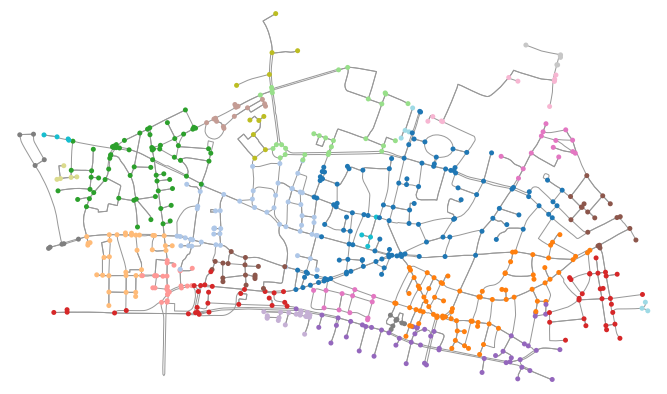

In [32]:
fig, ax = plt.subplots(figsize=(12,7))

fig, ax = ox.plot_graph(G, 
                        node_color=cls,
                        node_size = 25,
                        ax=ax)

In [33]:
104315

104315